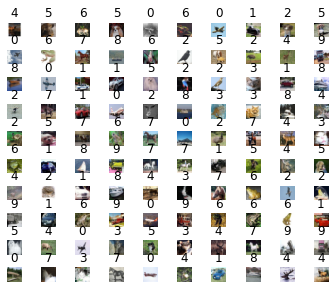

In [1]:
import tarfile
import numpy as np
import matplotlib.pyplot as plt

#****CIFARPATH NEEDS TO BE SET
#File Needs to be unzipped to '.tar' NOT '.tar.gz' & BINARY format
curr = os.getcwd()
cifarPath = os.path.join(curr,'cifar-10-binary.tar')

# Function for extracting cifar10 images from zip file into 5 training batches and one test batch
def cifar10_Load(path):    
    #Names of image batch files in cifar-10-python.tar
    batchNames = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']
    
    with tarfile.open(path) as tar_object:
         batchSize = 10000 * ( 32*32*3 + 1 )                     #Total number of bytes for each bin file. Each File Contains 10,000 32x32 color images with 10,000 labels
         totalBytes = np.zeros(batchSize*6, dtype="uint8")    #Total number bytes for all files. 5 Training & 1 Test files
         members = []
         for file in batchNames:
             members.append(tar_object.getmember(file))          #Gets members from tar file and ensures sorted from batch 1 to 5              

         for i, member in enumerate(members):                    #Retrieves byte data from all batch files
            f = tar_object.extractfile(member)
            totalBytes[i * batchSize:(i + 1) * batchSize] = np.frombuffer(f.read(), 'B')
    
    labels = totalBytes[::3073]
    images = np.delete(totalBytes, np.arange(0, totalBytes.size, 3073)).reshape(-1, 3072).astype('float32')/255 #Delete labels from totalbytes using array of label index locations then convert into 60,000 image x 3072 byte array (byte values in decimal value i.e. 255 = 0xFF)
    
    #print(labels[0:5])
    #print("--------------")
    #print(images[0:5,0:5])
    #print("--------------")
    
    trainImages = images[0:50000,:]
    trainLabels = labels[0:50000]
    testImages = images[50000:60000,:]
    testLabels = labels[50000:60000]
    
    return trainImages, trainLabels, testImages, testLabels


def random_IndexGen(numIndices):
    indices = np.random.randint(0,50000, numIndices)
    return indices


def image_Gen(imgArray, imgLabel, indices):
    #img1 = imgArray[110,:]
    imageHolder = np.zeros((32,32,3,len(indices))) 
    labelHolder = np.zeros(len(indices))
    for pic in range(0, len(indices)):
        img = imgArray[indices[pic],:]
        labelHolder[pic] = imgLabel[indices[pic]]
        for hue in range(0,3):
            for row in range(0,32):
                for col in range(0,32):
                    imageHolder[row,col,hue,pic] = img[1024*hue + 32*row + col]
    return imageHolder, labelHolder


def image_Display(images, labels):            #This assumes a 4 dimensional array with the 4 dimension representing image index
    numImages = images.shape[3]
    numCol = 10                               #Could be improved here to make number of Col/Rows dynamic and dependent on input data
    numRow = int(images.shape[3]/numCol)
    f, ax = plt.subplots(numRow,numCol)
    for row in range(0, numRow):
        for col in range(0, numCol):
            ax[row, col].imshow(images[:,:,:,10*row+col])
            ax[row, col].title.set_text(int(labels[10*row+col]))
            ax[row, col].axis('off')
    plt.subplots_adjust(top=0.95, bottom=0.05, wspace=0.2, hspace=0.9)
    plt.show()


#Load data from cifar10
trainImg, trainLbl, testImg, testLbl = cifar10_Load(cifarPath)
#Generate 100 Random Indices
randIndices = random_IndexGen(100)
#Format Byte Data input 4Dimensional Array
pictures, picLabels = image_Gen(trainImg, trainLbl, randIndices)
#Display Images
image_Display(pictures, picLabels)

In [1]:
import torch
import torch.cuda
import torchvision
import torchvision.transforms as transforms

# check if cuda is available and use it in the '.to(device)' methods used later if it is. If not, use cpu in the method.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Files already downloaded and verified
Files already downloaded and verified
9  - Happens to be the truck class


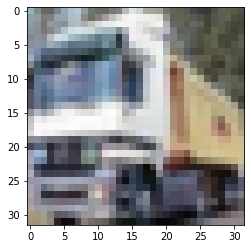

In [3]:

import torch.nn as nn
from torch.autograd import Variable

# Transforms are applied to each image. Some are mandatory, like conversion to Tensor and 
# Normalize the image. Others are optional and used for data augmentation (like random crop, 
# random jitter etc.)

transform = transforms.Compose([transforms.ToTensor(), 
                                # Various transforms can be added in this pipeline for data augmentation
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
len(trainset.data)
plt.imshow(trainset.data[1])
print(trainset.targets[1], " - Happens to be the truck class")

trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

In [10]:
# How many instances have we got?
print('# instances in training set: ', len(trainset.data))
print('# instances in testing/validation set: ', len(testset.data))


# instances in training set:  50000
# instances in testing/validation set:  10000


In [10]:
# Transpose train and test data to get features row-wise for nn model
trainData, trainLbl, testData, testLbl = trainImg.T, trainLbl.T, testImg.T, testLbl.T
print(trainData.shape)

trainLbl, testLbl = trainLbl.reshape(1,50000), testLbl.reshape(1, 10000)
print(trainLbl.shape)

trainD, trainL, testD, testL = torch.from_numpy(trainData), torch.from_numpy(trainLbl), torch.from_numpy(testData), torch.from_numpy(testLbl)
print(trainL.data.shape)

data = Variable(trainD)
print(data.data.shape)

(3072, 50000)
(1, 50000)
torch.Size([1, 50000])
torch.Size([3072, 50000])


In [5]:
class CifarNet(nn.Module):
    
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        
        super(CifarNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Our model
net = CifarNet(3072, 64, 32, 10).to(device)
print(net)

CifarNet(
  (fc1): Linear(in_features=3072, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [12]:

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, nesterov=True, momentum=0.9, dampening=0)

In [14]:
num_epochs = 10

# The following lists are appended every epoch
train_loss = []
test_loss = [] 
train_accuracy = []
test_accuracy = []

for epoch in range(num_epochs):
    
    train_correct = 0
    num_iters = trainD.shape[1]
    
    for i in range(num_iters):
        
        trainD = Variable(trainD.to(device))
        trainL = Variable(trainL.to(device))
        
        net.train()           # Put the network into training mode
        
        optimizer.zero_grad() # Clear off the gradients from any past operation
        outputs = net(trainD[:, i])  # Do the forward pass
        outputs = outputs.view(1,10) # transform to 2D so that 1 is read as batch size  
        #print(outputs)
        target = trainL[:, i].type(torch.LongTensor).to(device) # transform to Long from Byte for CE loss module
        #print(target)
        loss = criterion(outputs, target) # Calculate the loss
        loss.backward()       # Calculate the gradients with help of back propagation
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data   
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == trainL.data[0,i]).sum()
        
        if i%1000 == 0:         
            print ('Epoch %d/%d, Iteration %d/%d, Training Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, num_iters, loss.data))

    print('Number of correct training predicitons:', train_correct)
    
    # What was our train accuracy?
    train_accuracy.append((100 * train_correct / trainL.size(1)))
    train_loss.append(loss.data)
    
    print('Train accuracy after', epoch+1, 'epoch:', train_accuracy[epoch])
    print('Model trained for', epoch+1, 'epoch, now running predictions on test dataset...')
    
    # Record the correct predictions for test data

    for i in range(testD.shape[1]):
        
        net.eval()                 # Put the network into evaluation mode
        
        testD = Variable(testD.to(device))
        testL = Variable(testL.to(device))
        
        outputs = net(testD[:, i])
        outputs = outputs.view(1,10)
        target = testL[:, i].type(torch.LongTensor).to(device)
        loss = criterion(outputs, target)
        
        if i%1000 == 0:         
            print ('Epoch %d/%d, Iteration %d/%d, Test/Validation Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, testD.shape[1], loss.data))
        
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == testL.data[0,i]).sum()
    
    print('Number of correct test predicitons:', correct)
    
    test_loss.append(loss.data)
    test_accuracy.append((100 * correct / testL.size(1)))
    print('Test accuracy after', epoch+1, 'epoch:', test_accuracy[epoch])

Epoch 1/10, Iteration 1/50000, Training Loss: 2.2732
Epoch 1/10, Iteration 1001/50000, Training Loss: 2.1302
Epoch 1/10, Iteration 2001/50000, Training Loss: 2.6401
Epoch 1/10, Iteration 3001/50000, Training Loss: 2.1711
Epoch 1/10, Iteration 4001/50000, Training Loss: 2.7328
Epoch 1/10, Iteration 5001/50000, Training Loss: 1.7923
Epoch 1/10, Iteration 6001/50000, Training Loss: 2.1008
Epoch 1/10, Iteration 7001/50000, Training Loss: 2.4135
Epoch 1/10, Iteration 8001/50000, Training Loss: 2.8239
Epoch 1/10, Iteration 9001/50000, Training Loss: 2.3037
Epoch 1/10, Iteration 10001/50000, Training Loss: 2.8424
Epoch 1/10, Iteration 11001/50000, Training Loss: 1.8187
Epoch 1/10, Iteration 12001/50000, Training Loss: 2.0289
Epoch 1/10, Iteration 13001/50000, Training Loss: 1.7665
Epoch 1/10, Iteration 14001/50000, Training Loss: 1.6072
Epoch 1/10, Iteration 15001/50000, Training Loss: 3.0452
Epoch 1/10, Iteration 16001/50000, Training Loss: 1.7653
Epoch 1/10, Iteration 17001/50000, Training 

Epoch 3/10, Iteration 11001/50000, Training Loss: 1.4922
Epoch 3/10, Iteration 12001/50000, Training Loss: 1.9007
Epoch 3/10, Iteration 13001/50000, Training Loss: 1.1452
Epoch 3/10, Iteration 14001/50000, Training Loss: 1.7057
Epoch 3/10, Iteration 15001/50000, Training Loss: 2.4594
Epoch 3/10, Iteration 16001/50000, Training Loss: 1.7883
Epoch 3/10, Iteration 17001/50000, Training Loss: 2.2619
Epoch 3/10, Iteration 18001/50000, Training Loss: 0.6480
Epoch 3/10, Iteration 19001/50000, Training Loss: 1.4056
Epoch 3/10, Iteration 20001/50000, Training Loss: 1.9086
Epoch 3/10, Iteration 21001/50000, Training Loss: 0.9883
Epoch 3/10, Iteration 22001/50000, Training Loss: 2.1914
Epoch 3/10, Iteration 23001/50000, Training Loss: 2.1836
Epoch 3/10, Iteration 24001/50000, Training Loss: 1.6627
Epoch 3/10, Iteration 25001/50000, Training Loss: 0.9501
Epoch 3/10, Iteration 26001/50000, Training Loss: 2.4102
Epoch 3/10, Iteration 27001/50000, Training Loss: 1.7356
Epoch 3/10, Iteration 28001/500

Epoch 5/10, Iteration 22001/50000, Training Loss: 2.0353
Epoch 5/10, Iteration 23001/50000, Training Loss: 2.2706
Epoch 5/10, Iteration 24001/50000, Training Loss: 1.4930
Epoch 5/10, Iteration 25001/50000, Training Loss: 0.8915
Epoch 5/10, Iteration 26001/50000, Training Loss: 2.4569
Epoch 5/10, Iteration 27001/50000, Training Loss: 1.6172
Epoch 5/10, Iteration 28001/50000, Training Loss: 2.4623
Epoch 5/10, Iteration 29001/50000, Training Loss: 0.6161
Epoch 5/10, Iteration 30001/50000, Training Loss: 1.8128
Epoch 5/10, Iteration 31001/50000, Training Loss: 0.4617
Epoch 5/10, Iteration 32001/50000, Training Loss: 1.1697
Epoch 5/10, Iteration 33001/50000, Training Loss: 1.3180
Epoch 5/10, Iteration 34001/50000, Training Loss: 1.4327
Epoch 5/10, Iteration 35001/50000, Training Loss: 1.7545
Epoch 5/10, Iteration 36001/50000, Training Loss: 1.9129
Epoch 5/10, Iteration 37001/50000, Training Loss: 2.0835
Epoch 5/10, Iteration 38001/50000, Training Loss: 3.3614
Epoch 5/10, Iteration 39001/500

Epoch 7/10, Iteration 33001/50000, Training Loss: 2.0650
Epoch 7/10, Iteration 34001/50000, Training Loss: 1.9844
Epoch 7/10, Iteration 35001/50000, Training Loss: 1.6138
Epoch 7/10, Iteration 36001/50000, Training Loss: 2.2838
Epoch 7/10, Iteration 37001/50000, Training Loss: 2.1873
Epoch 7/10, Iteration 38001/50000, Training Loss: 3.2967
Epoch 7/10, Iteration 39001/50000, Training Loss: 0.9899
Epoch 7/10, Iteration 40001/50000, Training Loss: 0.3642
Epoch 7/10, Iteration 41001/50000, Training Loss: 2.6315
Epoch 7/10, Iteration 42001/50000, Training Loss: 1.4082
Epoch 7/10, Iteration 43001/50000, Training Loss: 1.2643
Epoch 7/10, Iteration 44001/50000, Training Loss: 0.2563
Epoch 7/10, Iteration 45001/50000, Training Loss: 0.3907
Epoch 7/10, Iteration 46001/50000, Training Loss: 1.8374
Epoch 7/10, Iteration 47001/50000, Training Loss: 1.3927
Epoch 7/10, Iteration 48001/50000, Training Loss: 2.2606
Epoch 7/10, Iteration 49001/50000, Training Loss: 0.8366
Number of correct training pred

Epoch 9/10, Iteration 44001/50000, Training Loss: 0.0518
Epoch 9/10, Iteration 45001/50000, Training Loss: 1.0197
Epoch 9/10, Iteration 46001/50000, Training Loss: 2.0821
Epoch 9/10, Iteration 47001/50000, Training Loss: 1.3609
Epoch 9/10, Iteration 48001/50000, Training Loss: 2.2271
Epoch 9/10, Iteration 49001/50000, Training Loss: 1.3580
Number of correct training predicitons: tensor(16445, device='cuda:0')
Train accuracy after 9 epoch: tensor(32.8900, device='cuda:0')
Model trained for 9 epoch, now running predictions on test dataset...
Epoch 9/10, Iteration 1/10000, Test/Validation Loss: 2.6040
Epoch 9/10, Iteration 1001/10000, Test/Validation Loss: 1.5145
Epoch 9/10, Iteration 2001/10000, Test/Validation Loss: 2.9259
Epoch 9/10, Iteration 3001/10000, Test/Validation Loss: 1.3831
Epoch 9/10, Iteration 4001/10000, Test/Validation Loss: 2.6899
Epoch 9/10, Iteration 5001/10000, Test/Validation Loss: 1.1694
Epoch 9/10, Iteration 6001/10000, Test/Validation Loss: 1.2692
Epoch 9/10, Iter

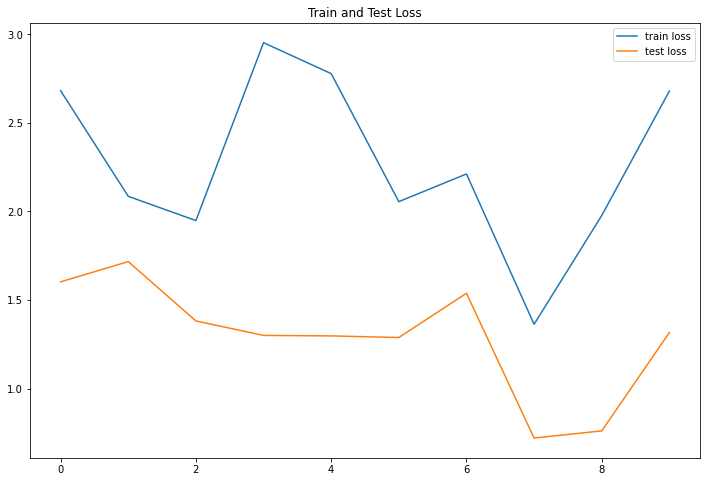

In [15]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title("Train and Test Loss")
plt.legend()
plt.show()

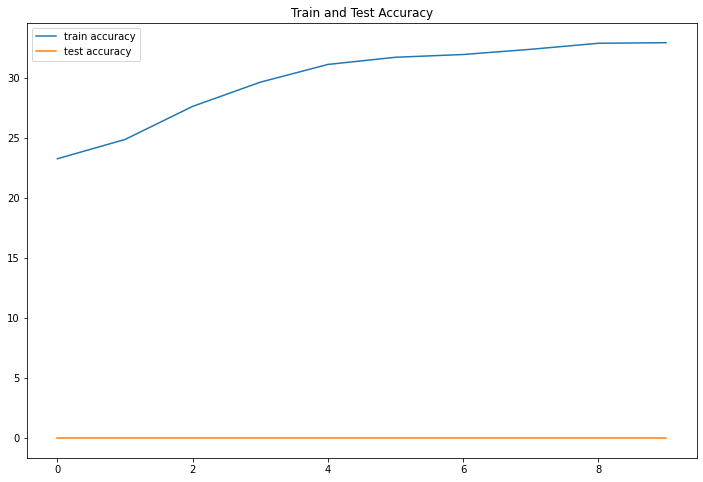

In [16]:
fig = plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
plt.legend()
plt.show()

Shuffle and normalize data!